### This notebooks uses EFD data to demonstrate the unexpected behavior we see when we issue the addAberration command twice in a row.

use summit = 2 to demonstrate following potential problems:
* evt_m2HexapodCorrection should correspond to aggregatedDOF instead of visitDOF

use summit = 1 to demonstrate following potential problems:
* 24s time off on MTAOS?
* m1m3 ao force logevent is published at 50Hz?
* are new corrections applied when I issue the z7 correction for the 2nd time?

In [1]:
from astropy.time import Time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
#summit = 1 #use this for summit testing
summit = 2
#summit = 0 #use this for NCSA

In [5]:
from lsst_efd_client import EfdClient

if summit:
    #client = EfdClient('summit_efd')
    client = EfdClient('ldf_stable_efd')
    if summit == 1:
        start = Time('2021-05-14T18:23:30', scale = 'tai')
        end = Time('2021-05-14T18:28:30', scale = 'tai')
    else:
        start = Time('2021-05-14T18:32:30', scale = 'tai')
        end = Time('2021-05-14T18:37:30', scale = 'tai')
else:
    client = EfdClient('ncsa_teststand_efd')
    start = Time('2021-05-14T18:23:30', scale = 'tai')
    end = Time('2021-05-14T18:25:30', scale = 'tai')
csc_index = 1

In [6]:
dfca = await client.select_time_series('lsst.sal.MTAOS.command_addAberration', '*', start, end, csc_index)
dfci = await client.select_time_series('lsst.sal.MTAOS.command_issueCorrection', '*', start, end, csc_index)
dfdof = await client.select_time_series('lsst.sal.MTAOS.logevent_degreeOfFreedom','*', start, end, csc_index)
dfsent = await client.select_time_series('lsst.sal.MTAOS.logevent_m2HexapodCorrection','*', start, end, csc_index)
dfapp = await client.select_time_series('lsst.sal.MTHexapod.logevent_uncompensatedPosition','*', start, end, csc_index)
dfapp = dfapp[dfapp.MTHexapodID==2]

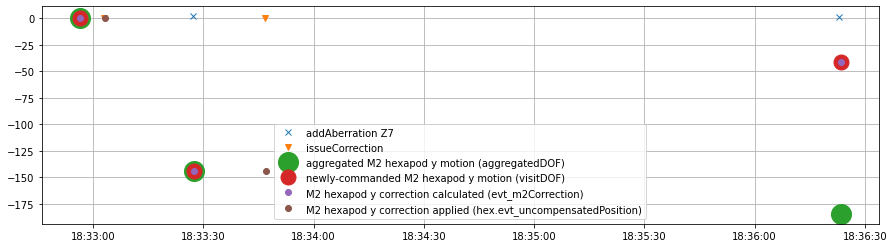

In [12]:
fig, ax = plt.subplots(1,1, figsize=(15,4))
plt.plot(dfca.wf3, 'x', label='addAberration Z7')
plt.plot(dfci.private_host, 'v', label='issueCorrection')
plt.plot(dfdof.aggregatedDoF2, 'o', markersize=20, label='aggregated M2 hexapod y motion (aggregatedDOF)')
plt.plot(dfdof.visitDoF2, 'o', markersize=15, label='newly-commanded M2 hexapod y motion (visitDOF)')
plt.plot(dfsent.y, 'o', label='M2 hexapod y correction calculated (evt_m2Correction)')
plt.plot(dfapp.y, 'o', label='M2 hexapod y correction applied (hex.evt_uncompensatedPosition)')
plt.legend(loc='lower center')
plt.grid();

In [13]:
#was a new move command issued? summit = 1: No; summit = 2: yes
dfapp

,MTHexapodID,priority,private_host,private_identity,private_kafkaStamp,private_origin,private_rcvStamp,private_revCode,private_seqNum,private_sndStamp,u,v,w,x,y,z
2021-05-14 18:33:03.227000+00:00,2,0,0,MTHexapod:2,1.621017e+09,28024,1.621017e+09,3723d561,9,1.621017e+09,0.000000,0.000000,0,0.000000,0.000000,0.000000
2021-05-14 18:33:47.094000+00:00,2,0,0,MTHexapod:2,1.621017e+09,28024,1.621017e+09,3723d561,10,1.621017e+09,0.006587,0.000005,0,-0.109839,-143.704721,-0.338241


m2 hexapod did not receive a new move command?
Let's check M2 forces

In [14]:
dfsent = await client.select_time_series('lsst.sal.MTAOS.logevent_m2Correction','*', start, end, csc_index)
dfapp = await client.select_time_series('lsst.sal.MTM2.axialForce','*', start, end, csc_index)

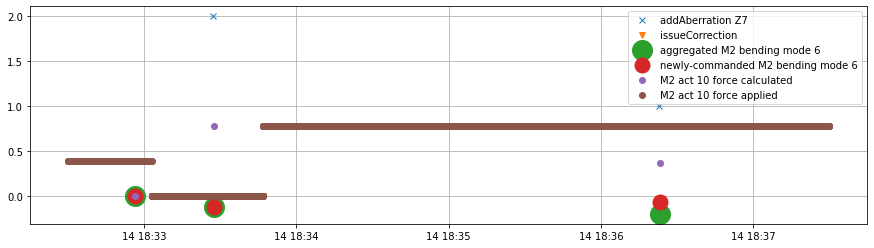

In [15]:
fig, ax = plt.subplots(1,1, figsize=(15,4))
plt.plot(dfca.wf3, 'x', label='addAberration Z7')
plt.plot(dfci.private_host, 'v', label='issueCorrection')
plt.plot(dfdof.aggregatedDoF35, 'o', markersize=20, label='aggregated M2 bending mode 6')
plt.plot(dfdof.visitDoF35, 'o', markersize=15, label='newly-commanded M2 bending mode 6')
plt.plot(dfsent.zForces10, 'o', label='M2 act 10 force calculated')
plt.plot(dfapp.applied10, 'o', label='M2 act 10 force applied')
plt.legend()
plt.grid();

In [98]:
a = np.array(dfapp.applied10)
idx = np.argmax(a>0.1)
dfapp.index[idx]-dfsent.index[0]

Timedelta('0 days 00:00:24.356000')

M2 doesn't acknowledge new force commands anyway. Let's look at M1M3

In [111]:
dfsent = await client.select_time_series('lsst.sal.MTAOS.logevent_m1m3Correction','*', start, end, csc_index)
dfapp = await client.select_time_series('lsst.sal.MTM1M3.logevent_appliedActiveOpticForces','*', start, end, csc_index)

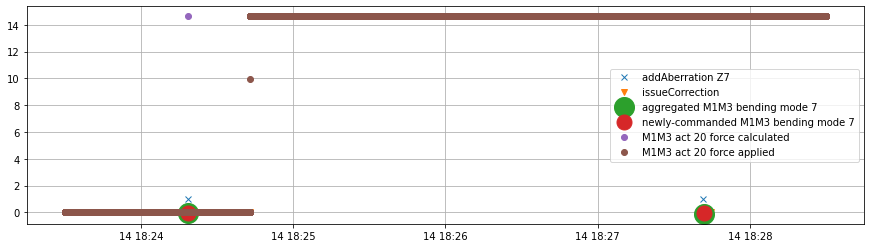

In [113]:
fig, ax = plt.subplots(1,1, figsize=(15,4))
plt.plot(dfca.wf3, 'x', label='addAberration Z7')
plt.plot(dfci.private_host, 'v', label='issueCorrection')
plt.plot(dfdof.aggregatedDoF16, 'o', markersize=20, label='aggregated M1M3 bending mode 7')
plt.plot(dfdof.visitDoF16, 'o', markersize=15, label='newly-commanded M1M3 bending mode 7')
plt.plot(dfsent.zForces19, 'o', label='M1M3 act 20 force calculated')
plt.plot(dfapp.zForces19, 'o', label='M1M3 act 20 force applied')
plt.legend()
plt.grid();

In [ ]:
ddd = await client.select_time_series('lsst.sal.MTM1M3.logevent_appliedActiveOpticForces','*', start, end, csc_index)

In [118]:
dfapp

,fz,mx,my,priority,private_host,private_identity,private_kafkaStamp,private_origin,private_rcvStamp,private_revCode,...,zForces90,zForces91,zForces92,zForces93,zForces94,zForces95,zForces96,zForces97,zForces98,zForces99
2021-05-14 18:23:30.006000+00:00,0.000000,0.000000,0.000000,0,1,MTM1M3,1.621017e+09,816,1.621017e+09,903d068f,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
2021-05-14 18:23:30.026000+00:00,0.000000,0.000000,0.000000,0,1,MTM1M3,1.621017e+09,816,1.621017e+09,903d068f,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
2021-05-14 18:23:30.046000+00:00,0.000000,0.000000,0.000000,0,1,MTM1M3,1.621017e+09,816,1.621017e+09,903d068f,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
2021-05-14 18:23:30.066000+00:00,0.000000,0.000000,0.000000,0,1,MTM1M3,1.621017e+09,816,1.621017e+09,903d068f,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
2021-05-14 18:23:30.086000+00:00,0.000000,0.000000,0.000000,0,1,MTM1M3,1.621017e+09,816,1.621017e+09,903d068f,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-14 18:28:29.908000+00:00,0.000036,-0.000038,-0.000008,0,1,MTM1M3,1.621017e+09,816,1.621017e+09,903d068f,...,-11.661302,-11.331948,-9.270344,-5.895171,-2.168063,1.233521,2.49719,-14.729892,-12.314339,-8.315075
2021-05-14 18:28:29.928000+00:00,0.000036,-0.000038,-0.000008,0,1,MTM1M3,1.621017e+09,816,1.621017e+09,903d068f,...,-11.661302,-11.331948,-9.270344,-5.895171,-2.168063,1.233521,2.49719,-14.729892,-12.314339,-8.315075
2021-05-14 18:28:29.948000+00:00,0.000036,-0.000038,-0.000008,0,1,MTM1M3,1.621017e+09,816,1.621017e+09,903d068f,...,-11.661302,-11.331948,-9.270344,-5.895171,-2.168063,1.233521,2.49719,-14.729892,-12.314339,-8.315075
2021-05-14 18:28:29.968000+00:00,0.000036,-0.000038,-0.000008,0,1,MTM1M3,1.621017e+09,816,1.621017e+09,903d068f,...,-11.661302,-11.331948,-9.270344,-5.895171,-2.168063,1.233521,2.49719,-14.729892,-12.314339,-8.315075


In [120]:
ddd = await client.select_time_series('lsst.sal.MTM1M3.logevent_appliedActiveOpticForces','*', start, end, csc_index)

In [123]:
a = np.array(dfapp.zForces19)
idx = np.argmax(a>1)
dfapp.index[idx]-dfsent.index[0]

Timedelta('0 days 00:00:24.279000')

In [125]:
dfapp.private_sndStamp[idx]-dfsent.private_sndStamp[0]

24.278987169265747

Are we continuously publishing logevent_appliedActiveOpticForces? We shouldn't.